<a href="https://colab.research.google.com/github/fatemeh190/cnn-registration/blob/master/Copy_of_registermnist1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torchir

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install pytorch_lightning

     |████████████████████████████████| 526 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 59.4 MB/s 
     |████████████████████████████████| 829 kB 69.0 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 332 kB 55.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 160 kB 53.8 MB/s 
     |████████████████████████████████| 192 kB 51.9 MB/s 
     |████████████████████████████████| 271 kB 44.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=bbd0283263d236b1ee3bf89ccd3773878ad9c7710ff9316e262d9b0d4e31b3b0
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 28 19:10:18 2021

@author: fakhoondi
"""

    
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
DEST_DIR = Path('./output')

import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
#from torchir.utils import IRDataSet

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import cv2


def identity_grid(shape, stackdim, dtype=torch.float32, device="cpu"):
    """Create an nd identity grid."""
    tensors = (torch.arange(s, dtype=dtype, device=device) for s in shape)
    return torch.stack(
        torch.meshgrid(*tensors)[::-1], stackdim
    )  # z,y,x shape and flip for x, y, z coords


class Resampler(nn.Module):
    """
    Generic resampler for 2D and 3D images.
    Expects voxel coordinates as coord_field
    Args:
        input (Tensor): input batch (N x C x IH x IW) or (N x C x ID x IH x IW)
        grid (Tensor): flow-field of size (N x OH x OW x 2) or (N x OD x OH x OW x 3)
        padding_mode (str): padding mode for outside grid values
            'zeros' | 'border'. Default: 'zeros'
    """

    def __init__(
        self, coord_dim: int = 1, mode: str = "bilinear", padding_mode: str = "border"
    ):
        super().__init__()
        self.mode = mode
        self.padding_mode = padding_mode
        self.coord_dim = coord_dim

    def forward(self, input, coord_grid):
        im_shape = input.shape[2:]
        assert coord_grid.shape[self.coord_dim] == len(
            im_shape
        )  # number of coordinates should match image dimension

        coord_grid = coord_grid.movedim(self.coord_dim, -1)

        # scale for pytorch grid_sample function
        max_extent = (
            torch.tensor(
                im_shape[::-1], dtype=coord_grid.dtype, device=coord_grid.device
            )
            - 1
        )
        coord_grid = 2 * (coord_grid / max_extent) - 1
        return F.grid_sample(
            input,
            coord_grid,
            mode=self.mode,
            padding_mode=self.padding_mode,
            align_corners=True,
        )


class StableStd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, tensor):
        assert tensor.numel() > 1
        ctx.tensor = tensor.detach()
        res = torch.std(tensor).detach()
        ctx.result = res.detach()
        return res

    @staticmethod
    def backward(ctx, grad_output):
        tensor = ctx.tensor.detach()
        result = ctx.result.detach()
        e = 1e-6
        assert tensor.numel() > 1
        return (
            (2.0 / (tensor.numel() - 1.0))
            * (grad_output.detach() / (result.detach() * 2 + e))
            * (tensor.detach() - tensor.mean().detach())
        )


stablestd = StableStd.apply


class ScaledTanH(nn.Module):
    def __init__(self, scaling):
        super().__init__()
        self.scaling = scaling

    def forward(self, input):
        return torch.tanh(input) * self.scaling

    def __repr__(self):
        return self.__class__.__name__ + "(" + "scaling = " + str(self.scaling) + ")"


class BiasedTanh(nn.Module):
    def __init__(self, scale_in=1.0, scale_out=1.0, bias=0.0):
        super().__init__()
        self.scale_in = scale_in
        self.scale_out = scale_out
        self.bias = bias

    def forward(self, input):
        return torch.tanh(input * self.scale_in) * self.scale_out + self.bias

    def __repr__(self):
        return (
            self.__class__.__name__
            + "("
            + "scale_in="
            + str(self.scale_in)
            + ", "
            + "scale_out="
            + str(self.scale_out)
            + ", "
            + "bias="
            + str(self.bias)
            + ")"
        )


class ScalingAF(nn.Module):
    def __init__(self, scale_factor):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, input):
        return self.scale_factor ** torch.tanh(input)

    def __repr__(self):
        return (
            self.__class__.__name__
            + "("
            + "scale_factor="
            + str(self.scale_factor)
            + ")"
        )


class IRDataSet(Dataset):
    """
    Wrapper to convert a dataset into a dataset suitable for image registration experiments.
    """

    def __init__(self, ds, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ds = ds

    def __len__(self):
        return len(self.ds) * len(self.ds)

    def __getitem__(self, idx):
        fixed_idx = idx // len(self.ds)
        moving_idx = idx % len(self.ds)
        return {"fixed": self.ds[fixed_idx], "moving": self.ds[moving_idx]}


# Bspline functions
def bspline_kernel_nd(t, order, dtype=float, **kwargs):
    tpowers = t ** torch.arange(order, 0 - 1, -1, dtype=dtype)
    if order == 1:
        return tpowers @ torch.tensor(((-1, 1), (1, 0)), dtype=dtype)
    elif order == 2:
        return (
            tpowers
            @ torch.tensor(((1, -2, 1), (-2, 2, 0), (1, 1, 0)), dtype=dtype)
            / 2.0
        )
    elif order == 3:
        return (
            tpowers
            @ torch.tensor(
                ((-1, 3, -3, 1), (3, -6, 3, 0), (-3, 0, 3, 0), (1, 4, 1, 0)),
                dtype=dtype,
            )
            / 6.0
        )


def bspline_convolution_kernel(upsampling_factors, order, dtype=float):
    ndim = len(upsampling_factors)
    for i, us_factor in enumerate(upsampling_factors):
        t = torch.linspace(1 - (1 / us_factor), 0, us_factor)
        ker1D = bspline_kernel_nd(t[:, None], order, dtype).T.flatten()
        shape = (1,) * i + ker1D.shape + (1,) * (ndim - 1 - i)
        try:
            kernel = kernel * ker1D.view(shape)
        except NameError:
            kernel = ker1D.view(shape)
    return kernel


# transform
def scaling_matrix_eff(x, ndim=2):
    assert (
        x.ndim == 2
    ), "Input should be a tensor of (m, n), where m is number of instances, and n number of parameters."
    assert ndim in (2, 3), "Only 2D and 3D implemented."
    assert ndim == x.shape[-1], f"Number of parameters for {ndim}D should be {ndim}."
    dtype, device = x.dtype, x.device
    T = torch.zeros((len(x), ndim, ndim), dtype=dtype, device=device)
    sel_mask = torch.eye(ndim, device=device, dtype=torch.bool)
    T[:, sel_mask] = x
    return T


def rotation_matrix_eff(x, axis=0, ndim=2):
    """
    For 3D axis = x: 2, y: 1, z: 0.
    """
    assert (
        x.ndim == 2 and x.shape[-1] == 1
    ), "Input should be a tensor of (m, 1), where m is number of instances."
    assert ndim in (2, 3), "Only 2D and 3D implemented."
    dtype, device = x.dtype, x.device
    T = torch.eye(ndim, dtype=dtype, device=device)[None].repeat(len(x), 1, 1)
    lidx, hidx = ((0, 1), (0, 2), (1, 2))[axis]
    c = torch.cos(x)
    s = torch.sin(x)
    T[:, lidx, lidx] = c.squeeze()
    T[:, lidx, hidx] = s.squeeze()
    T[:, hidx, lidx] = -s.squeeze()
    T[:, hidx, hidx] = c.squeeze()
    return T


def shearing_matrix_eff(x, ndim=2):
    assert (
        x.ndim == 2
    ), "Input should be a tensor of (m, n), where m is number of instances, and n number of parameters."
    assert ndim in (2, 3), "Only 2D and 3D implemented."
    assert (ndim - 1) * ndim == x.shape[
        -1
    ], f"Number of parameters for {ndim}D should be {(ndim - 1) * ndim}"
    dtype, device = x.dtype, x.device
    T = torch.eye(ndim, dtype=dtype, device=device)[None].repeat(len(x), 1, 1)
    T[:, ~torch.eye(ndim, device=device, dtype=torch.bool)] = torch.tan(x)
    return T


def translation_matrix(x, ndim=2):  # not used for efficient transforms
    assert (
        x.ndim == 2
    ), "Input should be a tensor of (m, n), where m is number of instances, and n number of parameters."
    assert ndim in (2, 3), "Only 2D and 3D implemented."
    assert ndim == x.shape[-1], f"Number of parameters for {ndim}D should be {ndim}."
    dtype, device = x.dtype, x.device
    T = torch.eye(ndim + 1, dtype=dtype, device=device)[None].repeat(len(x), 1, 1)
    T[:, :ndim, ndim] = x
    return T


def tmat_2d_affine(rotation, scale, shear):
    c = torch.cos(rotation[:, 0])
    s = torch.sin(rotation[:, 0])
    sx = scale[:, 0]
    sy = scale[:, 1]
    sh = torch.tan(shear[:, 0])
    T = torch.stack((sx * (c - s * sh), -s * sy, (sx * (s + c * sh)), sy * c)).view(
        -1, 2, 2
    )
    return T


shearmat2d = shearing_matrix_eff
rotmat2d = rotation_matrix_eff
scalemat2d = scaling_matrix_eff


def batch_transform_efficient(
    coord_grid, coord_dim, Tmat, translation, Forigin, Morigin
):
    # print(coord_grid.shape)
    coord_grid = coord_grid.movedim(coord_dim, -1)
    # print(coord_grid.shape)
    shape = coord_grid.shape
    coord_grid = coord_grid.view(shape[0], -1, shape[-1])  # flatten
    # print(coord_grid.shape, Forigin.shape)
    coord_grid = coord_grid + Forigin[:, None]
    coord_grid = coord_grid @ Tmat.transpose(
        2, 1
    )  # transpose because of switched order
    coord_grid = coord_grid + (translation[:, None] - Morigin[:, None])
    shape = (len(coord_grid),) + shape[1:]  # enable broadcasting
    coord_grid = coord_grid.view(shape)  # recover original shape
    coord_grid = coord_grid.movedim(-1, coord_dim)
    return coord_grid


def batch_transform(coord_grid, coord_dim, Tmat, Forigin, Morigin):
    coord_grid = coord_grid.movedim(coord_dim, -1)
    ndim = coord_grid.shape[-1]
    Tmat = translation_matrix(-Morigin) @ Tmat @ translation_matrix(Forigin)
    coord_grid = torch.cat(
        (
            coord_grid,
            torch.ones(
                coord_grid.shape[:-1] + (1,),
                dtype=coord_grid.dtype,
                device=coord_grid.device,
            ),
        ),
        dim=ndim + 1,
    )  # add extra dimension for MM
    shape = coord_grid.shape
    coord_grid = coord_grid.view(shape[0], -1, shape[-1])  # flatten
    coord_grid = coord_grid @ Tmat.transpose(2, 1)  # MM
    coord_grid = coord_grid.view(shape)  # recover shape
    coord_grid = coord_grid.narrow(ndim + 1, 0, ndim)  # remove extra dimension
    return coord_grid.movedim(-1, coord_dim)

rng = np.random.default_rng(404)
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
#ds_train_subset = MNISTSubSet(label=0, rng=rng, root='/content/drive/MyDrive/train1/',  transform=transform)
ds_train_subset = datasets.ImageFolder("/content/drive/MyDrive/00000005/" , transform=transform)
ds_test_subset = datasets.ImageFolder("/content/drive/MyDrive/00000004/", transform=transform)


ds_train_subset1 = torch.utils.data.DataLoader(ds_train_subset, batch_size=200, shuffle=False)
ds_test_subset1 = torch.utils.data.DataLoader(ds_test_subset, batch_size=200, shuffle=False)


ds_train_subset2, labels0 = next(iter(ds_train_subset1))
ds_test_subset2, labels1 = next(iter(ds_test_subset1))



In [ ]:
len(ds_test_subset2)

50

In [ ]:
ds_train_subset1[0][0].shape

In [ ]:
for i in range (len(ds_train_subset)):
    ds_train_subset1 , a =ds_train_subset[i]


In [ ]:
ds_train_subset2[900].shape

torch.Size([1, 512, 512])

In [ ]:
val_set_size =60
train_set_size = len(ds_train_subset2) - val_set_size
ds_train_subset2, ds_validation_subset2 = torch.utils.data.random_split(ds_train_subset2, [train_set_size, val_set_size], 
                                                        generator=torch.Generator().manual_seed(808))
#ds_test_subset = MNISTSubSet (rng=rng, root='/content/drive/MyDrive/data1/',  transform=transform, download=True, train=False)
print(f'Training subset size: {len(ds_train_subset2)}')
print(f'Validation subset size: {len(ds_validation_subset2)}')
print(f'Test subset size: {len(ds_test_subset2)}')


ds_train = IRDataSet(ds_train_subset2)
ds_validation = IRDataSet(ds_validation_subset2)
print(f'Training IR set size: {len(ds_train)}')
print(f'Validation IR set size: {len(ds_validation)}')


batch_size =32
training_batches = 50
validation_batches = 10

train_sampler = torch.utils.data.RandomSampler(ds_train, replacement=True, 
                                               num_samples=training_batches*batch_size, 
                                               generator=torch.Generator().manual_seed(404))
train_loader = torch.utils.data.DataLoader(ds_train, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(ds_validation, batch_size)


print(f'train_loader set size: {len(train_loader)}')
print(f'val_loader IR set size: {len(val_loader)}')



Training subset size: 140
Validation subset size: 60
Test subset size: 200
Training IR set size: 19600
Validation IR set size: 3600
train_loader set size: 50
val_loader IR set size: 113


In [ ]:
len(ds_train)

180

In [ ]:
ds_validation[0].shape

torch.Size([1, 512, 512])

In [ ]:
len(val_loader)

1

In [ ]:
import sys
sys.path.append('/content/gdrive/mypythondirectory')


!cp drive/MyDrive/TorchIR/torchir/networks/dirnet.py


#%%
import pytorch_lightning as pl

from collections import OrderedDict
from math import pi

import numpy as np
import torch
from torch import nn

from torchir.utils import ScaledTanH, ScalingAF
from torchir.utils import (
    rotation_matrix_eff,
    scaling_matrix_eff,
    shearing_matrix_eff,
)


class ConvBlock(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        downsample=(False,),
        af=nn.ELU,
        ndim=2,
    ):
        Conv = (nn.Conv2d, nn.Conv3d)[ndim - 2]
        AvgPool = (nn.AvgPool2d, nn.AvgPool3d)[ndim - 2]
        padding = kernel_size // 2
        layers = OrderedDict()
        layers["conv"] = Conv(
            in_channels, out_channels, kernel_size=kernel_size, padding=padding
        )
        if af:
            layers["af"] = af()
        if any(downsample):
            if any(np.asarray(downsample) > 1):  # TODO: improve checking
                layers["downsample"] = AvgPool(tuple(downsample))
        super().__init__(layers)


class AIRNet(nn.Module):
    def __init__(
        self,
        kernel_size=3,
        kernels=32,
        linear_nodes=64,
        num_conv_layers=5,
        num_dense_layers=2,
        num_downsamplings=4,
        ndim=2,
    ):
        super().__init__()
        # TODO: handle anisotropic grid spacings
        assert (
            num_dense_layers >= 1
        ), "Number of dense layers should at least be 1 (excluding the final dense output layer)."

        self.ndim = ndim
        AdaptiveAvgPool = (nn.AdaptiveAvgPool2d, nn.AdaptiveAvgPool3d)[ndim - 2]

        AF = nn.ELU

        self.max_scaling = 2
        self.max_rotation = 0.5 * pi
        self.max_shearing = 0.25 * pi

        in_channels = 1
        conv_layers = [
            ConvBlock(
                in_channels,
                kernels,
                kernel_size=kernel_size,
                downsample=(2,) * ndim,
                af=AF,
            )
        ]  # TODO: clean this hacky stuff
        for i in range(1, num_conv_layers):
            downsample = (
                (2,) * ndim if i < num_downsamplings else (1,) * ndim
            )  # TODO: clean this hacky stuff
            conv_layers.append(
                ConvBlock(
                    kernels,
                    kernels,
                    kernel_size=kernel_size,
                    downsample=downsample,
                    af=AF,
                )
            )
        conv_layers.append(AdaptiveAvgPool(1))
        self.convnet_features = nn.Sequential(*conv_layers)

        dense_layers = list()

        dense_layers.append(nn.Linear(2 * kernels, linear_nodes))
        dense_layers.append(AF(inplace=True))
        for i in range(1, num_dense_layers):
            dense_layers.append(nn.Linear(linear_nodes, linear_nodes))
            dense_layers.append(AF(inplace=True))

        self.regression_features = nn.Sequential(*dense_layers)

        self.translation = nn.Linear(linear_nodes, ndim)

        self.rotation = nn.Sequential(
            nn.Linear(linear_nodes, 1 if ndim == 2 else 3),
            ScaledTanH(self.max_rotation),
        )

        self.scaling = nn.Sequential(nn.Linear(linear_nodes, ndim), ScalingAF(2))

        self.shearing = nn.Sequential(
            nn.Linear(linear_nodes, (ndim - 1) * ndim), ScaledTanH(self.max_shearing)
        )

    def forward(self, fixed, moving):
        f = self.convnet_features(fixed)
        m = self.convnet_features(moving)
        x = torch.cat((f.flatten(1), m.flatten(1)), dim=1)
        x = self.regression_features(x)
        translation = self.translation(x)
        rotation = self.rotation(x)
        scale = self.scaling(x)
        shear = self.shearing(x)

        return translation, rotation, scale, shear


class RigidIRNet(nn.Module):
    def __init__(
        self,
        kernel_size=3,
        kernels=32,
        linear_nodes=64,
        num_conv_layers=5,
        num_dense_layers=2,
        num_downsamplings=4,
        ndim=2,
    ):
        super().__init__()
        # TODO: handle anisotropic grid spacings
        self.ndim = ndim
        AdaptiveAvgPool = (nn.AdaptiveAvgPool2d, nn.AdaptiveAvgPool3d)[ndim - 2]

        AF = nn.ELU

        self.max_rotation = 0.5 * pi

        in_channels = 1
        conv_layers = [
            ConvBlock(
                in_channels,
                kernels,
                kernel_size=kernel_size,
                downsample=(2,) * ndim,
                af=AF,
            )
        ]  # TODO: clean this hacky stuff
        for i in range(1, num_conv_layers):
            downsample = (
                (2,) * ndim if i < num_downsamplings else (1,) * ndim
            )  # TODO: clean this hacky stuff
            conv_layers.append(
                ConvBlock(
                    kernels,
                    kernels,
                    kernel_size=kernel_size,
                    downsample=downsample,
                    af=AF,
                )
            )
        conv_layers.append(AdaptiveAvgPool(1))
        self.convnet_features = nn.Sequential(*conv_layers)

        dense_layers = list()
        for i in range(0, num_dense_layers):
            dense_layers.append(nn.Linear(linear_nodes, linear_nodes))
            dense_layers.append(AF(inplace=True))

        self.regression_features = nn.Sequential(*dense_layers)

        self.translation = nn.Linear(linear_nodes, ndim)

        self.rotation = nn.Sequential(
            nn.Linear(linear_nodes, 1 if ndim == 2 else 3),
            ScaledTanH(self.max_rotation),
        )

    def forward(self, fixed, moving):
        f = self.convnet_features(fixed)
        m = self.convnet_features(moving)
        x = torch.cat((f.flatten(1), m.flatten(1)), dim=1)
        x = self.regression_features(x)
        translation = self.translation(x)
        rotation = self.rotation(x)

        # TODO: The model should probably not be tasked with creating a transformation matrix.
        if self.ndim == 2:
            Tmat = rotation_matrix_eff(rotation, ndim=self.ndim)
        elif self.ndim == 3:
            Tmat = (
                rotation_matrix_eff(rotation[:, 0], axis=2, ndim=self.ndim)
                @ rotation_matrix_eff(rotation[:, 1], axis=1, ndim=self.ndim)
                @ rotation_matrix_eff(rotation[:, 2], axis=0, ndim=self.ndim)
            )

        return Tmat, translation


import math
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn.modules.loss import _Loss

from torchir.utils import stablestd


# TODO: add masks.
def ncc(x1, x2, e=1e-10):
    assert x1.shape == x2.shape, "Inputs are not of equal shape"
    cc = ((x1 - x1.mean()) * (x2 - x2.mean())).mean()
    std = stablestd(x1) * stablestd(x2)
    ncc = cc / (std + e)
    return ncc


def ncc_mask(x1, x2, mask, e=1e-10):  # TODO: calculate ncc per sample
    assert x1.shape == x2.shape, "Inputs are not of equal shape"
    x1 = torch.masked_select(x1, mask)
    x2 = torch.masked_select(x2, mask)
    cc = ((x1 - x1.mean()) * (x2 - x2.mean())).mean()
    std = stablestd(x1) * stablestd(x2)
    ncc = cc / (std + e)
    return ncc


class NCC(_Loss):
    def __init__(self, use_mask: bool = False):
        super().__init__()
        if use_mask:
            self.forward = self.masked_metric
        else:
            self.forward = self.metric

    def metric(self, fixed: Tensor, warped: Tensor) -> Tensor:
        return -ncc(fixed, warped)

    def masked_metric(self, fixed: Tensor, warped: Tensor, mask: Tensor) -> Tensor:
        return -ncc_mask(fixed, warped, mask)


def nmi_gauss(x1, x2, x1_bins, x2_bins, sigma=1e-3, e=1e-10):
    assert x1.shape == x2.shape, "Inputs are not of similar shape"

    def gaussian_window(x, bins, sigma):
        assert x.ndim == 2, "Input tensor should be 2-dimensional."
        return torch.exp(
            -((x[:, None, :] - bins[None, :, None]) ** 2) / (2 * sigma ** 2)
        ) / (math.sqrt(2 * math.pi) * sigma)

    x1_windowed = gaussian_window(x1.flatten(1), x1_bins, sigma)
    x2_windowed = gaussian_window(x2.flatten(1), x2_bins, sigma)
    p_XY = torch.bmm(x1_windowed, x2_windowed.transpose(1, 2))
    p_XY = p_XY + e  # deal with numerical instability

    p_XY = p_XY / p_XY.sum((1, 2))[:, None, None]

    p_X = p_XY.sum(1)
    p_Y = p_XY.sum(2)

    I = (p_XY * torch.log(p_XY / (p_X[:, None] * p_Y[:, :, None]))).sum((1, 2))

    marg_ent_0 = (p_X * torch.log(p_X)).sum(1)
    marg_ent_1 = (p_Y * torch.log(p_Y)).sum(1)

    normalized = -1 * 2 * I / (marg_ent_0 + marg_ent_1)  # harmonic mean

    return normalized


def nmi_gauss_mask(x1, x2, x1_bins, x2_bins, mask, sigma=1e-3, e=1e-10):
    def gaussian_window_mask(x, bins, sigma):

        assert x.ndim == 1, "Input tensor should be 2-dimensional."
        return torch.exp(-((x[None, :] - bins[:, None]) ** 2) / (2 * sigma ** 2)) / (
            math.sqrt(2 * math.pi) * sigma
        )

    x1_windowed = gaussian_window_mask(torch.masked_select(x1, mask), x1_bins, sigma)
    x2_windowed = gaussian_window_mask(torch.masked_select(x2, mask), x2_bins, sigma)
    p_XY = torch.mm(x1_windowed, x2_windowed.transpose(0, 1))
    p_XY = p_XY + e  # deal with numerical instability

    p_XY = p_XY / p_XY.sum()

    p_X = p_XY.sum(0)
    p_Y = p_XY.sum(1)

    I = (p_XY * torch.log(p_XY / (p_X[None] * p_Y[:, None]))).sum()

    marg_ent_0 = (p_X * torch.log(p_X)).sum()
    marg_ent_1 = (p_Y * torch.log(p_Y)).sum()

    normalized = -1 * 2 * I / (marg_ent_0 + marg_ent_1)  # harmonic mean

    return normalized


class NMI(_Loss):
    """Normalized mutual information metric.

    As presented in the work by `De Vos 2020: <https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11313/113130R/Mutual-information-for-unsupervised-deep-learning-image-registration/10.1117/12.2549729.full?SSO=1>`_

    """

    def __init__(
        self,
        intensity_range: Optional[Tuple[float, float]] = None,
        nbins: int = 32,
        sigma: float = 0.1,
        use_mask: bool = False,
    ):
        super().__init__()
        self.intensity_range = intensity_range
        self.nbins = nbins
        self.sigma = sigma
        if use_mask:
            self.forward = self.masked_metric
        else:
            self.forward = self.metric

    def metric(self, fixed: Tensor, warped: Tensor) -> Tensor:
        with torch.no_grad():
            if self.intensity_range:
                fixed_range = self.intensity_range
                warped_range = self.intensity_range
            else:
                fixed_range = fixed.min(), fixed.max()
                warped_range = warped.min(), warped.max()

        bins_fixed = torch.linspace(
            fixed_range[0],
            fixed_range[1],
            self.nbins,
            dtype=fixed.dtype,
            device=fixed.device,
        )
        bins_warped = torch.linspace(
            warped_range[0],
            warped_range[1],
            self.nbins,
            dtype=fixed.dtype,
            device=fixed.device,
        )

        return -nmi_gauss(
            fixed, warped, bins_fixed, bins_warped, sigma=self.sigma
        ).mean()

    def masked_metric(self, fixed: Tensor, warped: Tensor, mask: Tensor) -> Tensor:
        with torch.no_grad():
            if self.intensity_range:
                fixed_range = self.intensity_range
                warped_range = self.intensity_range
            else:
                fixed_range = fixed.min(), fixed.max()
                warped_range = warped.min(), warped.max()

        bins_fixed = torch.linspace(
            fixed_range[0],
            fixed_range[1],
            self.nbins,
            dtype=fixed.dtype,
            device=fixed.device,
        )
        bins_warped = torch.linspace(
            warped_range[0],
            warped_range[1],
            self.nbins,
            dtype=fixed.dtype,
            device=fixed.device,
        )

        return -nmi_gauss_mask(
            fixed, warped, bins_fixed, bins_warped, mask, sigma=self.sigma
        )


from abc import ABC, abstractmethod
from typing import Optional, Tuple, Union

import numpy as np
import torch
from torch import nn, Tensor, Size
import torch.nn.functional as F

from torchir.utils import identity_grid, Resampler
from torchir.utils import bspline_convolution_kernel
from torchir.utils import (
    batch_transform_efficient,
    rotation_matrix_eff,
    shearing_matrix_eff,
    scaling_matrix_eff,
)


class Transformer(ABC, nn.Module):
    def __init__(self, ndim: int, coord_dim: int = 1):
        super().__init__()
        self.ndim = ndim
        self.coord_dim = coord_dim
        self._resampler = Resampler(coord_dim=coord_dim)

    @abstractmethod
    def apply_transform(
        self,
        parameters: Tensor,
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Optional[Tensor] = None,
    ) -> Tensor:
        """apply the parameters to get the transformed coord_grid"""
        pass

    def forward(
        self,
        parameters: Tensor,
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Optional[Tensor] = None,
        return_coordinate_grid: bool = False,
    ) -> Tuple[Tensor]:

        coordinate_grid = self.apply_transform(
            parameters, fixed_image, moving_image, coordinate_grid
        )

        ret = self._resampler(moving_image, coordinate_grid)
        if return_coordinate_grid:
            ret = (ret, coordinate_grid)
        return ret


class BsplineTransformer(Transformer):
    """
    third order bspline. upsampling via transposed convolutions.
    """

    def __init__(
        self,
        *args,
        upsampling_factors: Tuple[int],
        order: int = 3,
        trainable: bool = False,
        apply_diffeomorphic_limits: bool = False,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.upsampling_factors = upsampling_factors
        ConvTranspose = (nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d)[
            self.ndim - 1
        ]

        bspline_kernel = self.make_bspline_kernel(self.upsampling_factors, order=order)
        kernel_size = bspline_kernel.shape
        crop_size = tuple(int(el * 3 / 8) if el != 5 else 2 for el in kernel_size)
        upsampler = ConvTranspose(
            1,
            1,
            kernel_size,
            stride=self.upsampling_factors,
            padding=crop_size,
            bias=False,
        )
        upsampler.weight = nn.Parameter(
            bspline_kernel[None, None], requires_grad=trainable
        )

        self._upsampler = upsampler
        self.apply_diffeomorphic_limits = apply_diffeomorphic_limits

    @staticmethod
    def make_bspline_kernel(upsampling_factors, order, dtype=torch.float32):
        # TODO: solve the issues with kernel shapes
        bspline_kernel = bspline_convolution_kernel(
            upsampling_factors, order=order, dtype=dtype
        )

        if (np.array(bspline_kernel.shape[::-1]) == 4).any() or (
            np.array(bspline_kernel.shape[::-1]) == 2
        ).any():  # hack to deal with 1 strides and kernel size of 4
            padding = list()
            for s in bspline_kernel.shape[::-1]:
                if s == 4 or s == 2:
                    padding.extend([1, 0])
                else:
                    padding.extend([0, 0])
            bspline_kernel = F.pad(bspline_kernel, padding, mode="constant")

        return bspline_kernel

    def create_dvf(self, bspline_parameters, output_shape):
        assert bspline_parameters.shape[1] == self.ndim
        shape = bspline_parameters.shape
        dvf = self._upsampler(
            bspline_parameters.view((shape[0] * self.ndim, 1) + shape[2:]),
            output_size=output_shape,
        )
        newshape = dvf.shape

        return dvf.view((shape[0], self.ndim) + newshape[2:])

    def apply_transform(
        self,
        bspline_coefficients: Tensor,
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Tensor = None,
    ):
        device = bspline_coefficients.device
        dtype = bspline_coefficients.dtype
        if self.apply_diffeomorphic_limits:
            bspline_coefficients = torch.tanh(bspline_coefficients) * (
                0.4
                * torch.tensor(
                    self.upsampling_factors[::-1],
                    dtype=dtype,
                    device=device,
                ).view((1, self.ndim) + (1,) * self.ndim)
            )

        shape = fixed_image.shape[2:]
        dvf = self.create_dvf(bspline_coefficients, output_shape=shape)
        new_grid = dvf + identity_grid(
            dvf.shape[2:], stackdim=0, dtype=dtype, device=device
        )
        if coordinate_grid is not None:
            assert shape == coordinate_grid.shape[2:]
            new_grid = self._resampler(coordinate_grid, new_grid)
        return new_grid


class AffineTransformer(Transformer):
    def apply_transform(
        self,
        parameters: Tuple[Tensor],
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Optional[Tensor] = None,
    ) -> Tensor:
        """
        :param parameters: translation, rotation, scale, shear
        :param fixed_image:
        :param moving_image:
        :param coordinate_grid:
        :return:

        Note: If ndim == 3, number of parameters are 3 for translation, rotation, and scale; and
        6 for shear. If ndim == 2, number of parameters are 2 for translation, scale, and shear;
        and 1 for rotation
        """
        translation, rotation, scale, shear = parameters

        if self.ndim == 2:
            rot_mat = rotation_matrix_eff(rotation, ndim=self.ndim)
        elif self.ndim == 3:
            rot_mat = (
                rotation_matrix_eff(rotation[:, 0], axis=2, ndim=self.ndim)
                @ rotation_matrix_eff(rotation[:, 1], axis=1, ndim=self.ndim)
                @ rotation_matrix_eff(rotation[:, 2], axis=0, ndim=self.ndim)
            )

        Tmat = (
            scaling_matrix_eff(scale, ndim=self.ndim)
            @ shearing_matrix_eff(shear, ndim=self.ndim)
            @ rot_mat
        )

        f_origin = -(
            torch.tensor(
                fixed_image.shape[2:],
                dtype=fixed_image.dtype,
                device=fixed_image.device,
            )[None]
            / 2
        )
        m_origin = -(
            torch.tensor(
                moving_image.shape[2:],
                dtype=moving_image.dtype,
                device=moving_image.device,
            )[None]
            / 2
        )

        if coordinate_grid is None:
            coordinate_grid = identity_grid(
                fixed_image.shape[2:],
                stackdim=0,
                dtype=fixed_image.dtype,
                device=fixed_image.device,
            )[None].movedim(1, self.coord_dim)

        coordinate_grid = batch_transform_efficient(
            coordinate_grid, self.coord_dim, Tmat, translation, f_origin, m_origin
        )

        return coordinate_grid


class DirectDVFTransformer(Transformer):
    def apply_transform(
        self,
        dvf: Tensor,
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Optional[Tensor] = None,
    ) -> Tensor:
        return dvf


class DiffeomorphicFlowTransformer(Transformer):
    """
    Implementation for diffeormorphic DVFs as used in `Voxelmorph <https://github.com/voxelmorph/voxelmorph>`_.
    Uses scaling and squaring of a velocity field to obtain a diffeomorphic DVF.
    """

    def __init__(self, *args, nsteps=8, **kwargs):
        super().__init__(*args, **kwargs)

        assert nsteps >= 0, f"nsteps should be >= 0"
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)

    def scaling_squaring(self, flow_field):
        flow_field = flow_field * self.scale
        for _ in range(self.nsteps):
            grid = identity_grid(
                flow_field.shape[2:],
                stackdim=0,
                device=flow_field.device,
                dtype=flow_field.dtype,
            )[None].movedim(1, self.coord_dim)
            flow_field = flow_field + self._resampler(flow_field, flow_field + grid)
        return flow_field

    def apply_transform(
        self,
        flow_field: Tensor,
        fixed_image: Tensor,
        moving_image: Tensor,
        coordinate_grid: Optional[Tensor] = None,
    ) -> Tensor:
        dvf = self.scaling_squaring(flow_field)
        device = dvf.device
        dtype = dvf.dtype
        new_grid = dvf + identity_grid(
            dvf.shape[2:], stackdim=0, dtype=dtype, device=device
        )
        if coordinate_grid:
            new_grid = self._resampler(coordinate_grid, new_grid)
        return new_grid

from collections import OrderedDict

import numpy as np
import torch
from torch import nn
from torch.nn.modules.utils import _ntuple


class ConvBlock(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        downsample=(False,),
        af=nn.ELU,
        ndim=2,
    ):
        Conv = (nn.Conv2d, nn.Conv3d)[ndim - 2]
        AvgPool = (nn.AvgPool2d, nn.AvgPool3d)[ndim - 2]
        padding = kernel_size // 2
        layers = OrderedDict()
        layers["conv"] = Conv(
            in_channels, out_channels, kernel_size=kernel_size, padding=padding
        )
        if af:
            layers["af"] = af()
        if any(downsample):
            if any(np.asarray(downsample) > 1):  # TODO: improve checking
                layers["downsample"] = AvgPool(tuple(downsample))
        super().__init__(layers)


class DIRNet(nn.Module):
    def __init__(
        self,
        grid_spacing,
        kernel_size=3,
        kernels=32,
        num_conv_layers=5,
        num_dense_layers=2,
        ndim=2,
    ):
        super().__init__()
        grid_spacing = _ntuple(ndim)(grid_spacing)
        self.grid_spacing = grid_spacing

        AF = torch.nn.ELU

        num_downsamplings = np.log2(grid_spacing)
        assert all(
            num_downsamplings == num_downsamplings.round()
        ), "Grid spacing should be factors of 2."
        num_downsamplings = num_downsamplings.astype(int)

        in_channels = 2
        downsample = (0 < num_downsamplings).astype(np.int) + 1  # downsample kernel
        conv_layers = [
            ConvBlock(
                in_channels,
                kernels,
                kernel_size=kernel_size,
                downsample=downsample,
                af=AF,
                ndim=ndim,
            )
        ]
        for i in range(1, num_conv_layers):
            downsample = (i < num_downsamplings).astype(np.int) + 1  # downsample kernel
            conv_layers.append(
                ConvBlock(
                    kernels,
                    kernels,
                    kernel_size=kernel_size,
                    downsample=downsample,
                    af=AF,
                    ndim=ndim,
                )
            )

        dense_layers = [
            ConvBlock(kernels, kernels, kernel_size=1, af=AF, ndim=ndim)
            for _ in range(num_dense_layers)
        ]
        dense_layers.append(
            ConvBlock(kernels, ndim, kernel_size=1, af=None, ndim=ndim)
        )  # linear activation for b-spline coeffs.
        dense_layers[-1].conv.weight.data.fill_(0.0)
        dense_layers[-1].conv.bias.data.fill_(0.0)
        self.conv_layers = nn.Sequential(*conv_layers)
        self.dense_layers = nn.Sequential(*dense_layers)
        self.ndim = ndim

    def forward(self, fixed, moving=None):
        x = fixed
        if moving is not None:
            x = torch.cat((fixed, moving), 1)

        x = self.conv_layers(x)
        x = self.dense_layers(x)

        return x




class LitDIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        grid_spacing = (8, 8)
        self.dirnet = DIRNet(kernels=16, grid_spacing=grid_spacing)
        self.bspline_transformer = BsplineTransformer(ndim=2, upsampling_factors=grid_spacing)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = torch.optim.Adam(self.dirnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        params = self.dirnet(fixed, moving)
        warped = self.bspline_transformer(params, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  
 
    
model = LitDIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR, 
                     log_every_n_steps=10,
                     val_check_interval=10, 
                     max_epochs=100) 
                    # gpus=1)
trainer.fit(model, train_loader, val_loader)



from pathlib import Path
DEST_DIR = Path('/content/drive/MyDrive/TorchIR')
# trainer.save_checkpoint('mnist_ir_8.ckpt')
trainer.save_checkpoint(DEST_DIR / 'mnist_ir_affine7.ckpt')


cp: missing destination file operand after 'drive/MyDrive/TorchIR/torchir/networks/dirnet.py'
Try 'cp --help' for more information.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: output/lightning_logs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | dirnet              | DIRNet             | 10.2 K
1 | bspline_transformer | BsplineTransformer | 1.0 K 
2 | metric              | NCC                | 0     
-----------------------------------------------------------
10.2 K    Trainable params
1.0 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
ds_test_subset[0][0].shape


torch.Size([1, 512, 512])

In [ ]:
fixed = ds_test_subset2[0]

fixed.shape

torch.Size([1, 512, 512])

In [ ]:
moving = ds_test_subset2[1]

moving.shape

torch.Size([1, 512, 512])

In [ ]:
fixed1 = fixed.unsqueeze(1)
moving1 = moving.unsqueeze(1)

moving1.shape

torch.Size([1, 1, 512, 512])

In [ ]:
fixed1.shape

torch.Size([950, 1, 1, 512, 512])

In [ ]:
warped = model(fixed1, moving1)

In [ ]:
model = LitDIRNet.load_from_checkpoint('/content/drive/MyDrive/TorchIR/mnist_ir_affine6.ckpt')

#print(model.learning_rate)
# prints the learning_rate you used in this checkpoint

model.eval()

LitDIRNet(
  (dirnet): DIRNet(
    (conv_layers): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (af): ELU(alpha=1.0)
        (downsample): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      )
      (1): ConvBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (af): ELU(alpha=1.0)
        (downsample): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      )
      (2): ConvBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (af): ELU(alpha=1.0)
        (downsample): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      )
      (3): ConvBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (af): ELU(alpha=1.0)
      )
      (4): ConvBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (af): ELU(alpha=1.0)
      )


In [ ]:


trainer = pl.Trainer(default_root_dir=DEST_DIR, 
                     log_every_n_steps=50,
                     val_check_interval=50, 
                     max_epochs=100) 
                    # gpus=1)
trainer.fit(model, train_loader, val_loader)



from pathlib import Path
DEST_DIR = Path('/content/drive/MyDrive/TorchIR')
# trainer.save_checkpoint('mnist_ir_8.ckpt')
trainer.save_checkpoint(DEST_DIR / 'mnist_ir_affine6.ckpt')


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | dirnet              | DIRNet             | 10.2 K
1 | bspline_transformer | BsplineTransformer | 1.0 K 
2 | metric              | NCC                | 0     
-----------------------------------------------------------
10.2 K    Trainable params
1.0 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


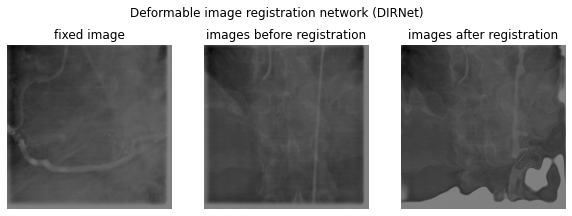

In [ ]:


avg_moving = np.zeros((512, 512), dtype=float)
avg_warped = np.zeros((512, 512), dtype=float)
model = model
model.eval()
fixed = ds_test_subset2[160]

moving = ds_test_subset2[170]

with torch.no_grad():

   # for moving in tqdm(ds_test_subset2):
        fixed1 = fixed.unsqueeze(1)
        moving1 = moving.unsqueeze(1)
        warped = model(fixed1, moving1).detach().squeeze().cpu().numpy()
        avg_moving += moving1.squeeze().cpu().numpy() 
        avg_warped += warped 
                
        
fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('Deformable image registration network (DIRNet)');


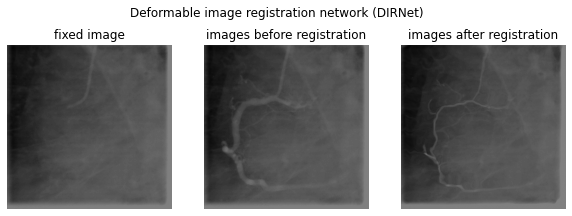

In [ ]:


avg_moving = np.zeros((512, 512), dtype=float)
avg_warped = np.zeros((512, 512), dtype=float)
model = model
model.eval()
fixed = ds_test_subset2[100]
moving = ds_test_subset2[120]

with torch.no_grad():
  #  for moving in tqdm(ds_test_subset2[120:160]):
        fixed1 = fixed.unsqueeze(1)
        moving1 = moving.unsqueeze(1)
        warped = model(fixed1, moving1).detach().squeeze().cpu().numpy()
        avg_moving += moving1.squeeze().cpu().numpy() / len(ds_test_subset2)
        avg_warped += warped 
        
        
        
fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
axarr[0].imshow(-fixed1[0][0].squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-moving1[0][0], cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('Deformable image registration network (DIRNet)');


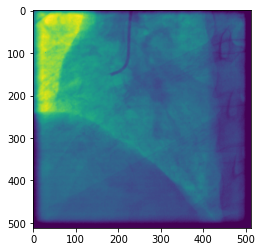

In [ ]:
a= moving
#a1 = a.permute(1, 2, 0)
#a1.shape
plt.imshow(a[0],gra)


In [ ]:
moving[0].shape

torch.Size([1, 512, 512])

In [ ]:
#%%        
 
from torchir.networks import AIRNet
from torchir.transformers import AffineTransformer
import pytorch_lightning as pl
from torchir.networks import DIRNet
from torchir.metrics import NCC
from torchir.transformers import BsplineTransformer


class LitAIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.airnet = AIRNet(kernels=16)
        self.global_transformer = AffineTransformer(ndim=2)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = torch.optim.Adam(self.airnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        parameters = self.airnet(fixed, moving)
        warped  = self.global_transformer(parameters, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  


model = LitAIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100)

trainer.fit(model, train_loader)

trainer.save_checkpoint(DEST_DIR / 'mnist_ir_affine.ckpt')


avg_moving = np.zeros((512, 512), dtype=float)
avg_warped = np.zeros((512, 512), dtype=float)
model = model
fixed = ds_test_subset[0]
for moving in tqdm(ds_test_subset):
    warped = model(fixed[None], moving[None]).detach().squeeze().cpu().numpy()
    avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
    avg_warped += warped / len(ds_test_subset)




fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
for ax in axarr.ravel():
    ax.axis('off')

axarr[0].set_title('fixed image')
axarr[1].set_title('images before registration')
axarr[2].set_title('images after registration')

fig.suptitle('Affine image registration network (AIRNet)');

ModuleNotFoundError: ignored